# ICE 2
Appliance watt predictions

# Imports

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import heapq
import joblib
import random
import datetime
import os
import xgboost as xgb
import tensorflow as tf
from IPython.display import display
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, root_mean_squared_log_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from datetime import datetime

# Dataset

In [120]:
training_df = pd.read_csv('./ICE-2/energy-training.csv')
holdout_df = pd.read_csv('./ICE-2/energy-holdout.csv')

## Data Evaluation

In [ ]:
training_df.info()

## Feature Engineering

In [121]:
def create_weekday(y, m, d):
    s_obj = datetime.date(int(y), int(m), int(d))
    s_day = s_obj.strftime("%a")
    return day_map[s_day]
    # return s_day

def convert_time_cyclic(h, m, h_max, h_min, m_max, m_min):
    return (np.cos((h - h_min + (m / m_max)) / (h_max + m_max - (h_min + m_min)) * np.pi) + 1) / 2

day_map = {
    'Sun': 0,
    'Mon': 1,
    'Tue': 2,
    'Wed': 3,
    'Thu': 4,
    'Fri': 5,
    'Sat': 6
}

In [122]:
# Also get the weekday
training_df['Weekday'] = training_df.apply(lambda row: create_weekday(row['Year'], row['Month'], row['Day']), axis=1)

hour_max = training_df['Hours'].max()
hour_min = training_df['Hours'].min()
minutes_max = training_df['Minutes'].max()
minutes_min = training_df['Minutes'].min()

# training_df['Hours_Cyclic'] = (np.cos((training_df['Hours'] - hour_min) / (hour_max - hour_min) * np.pi) + 1) / 2
# training_df['Minuts_Cyclic'] = (np.cos((training_df['Minutes'] - minutes_min) / (minutes_max - minutes_min) * np.pi) + 1) / 2
# training_df['Time_Cyclic'] = (np.cos((training_df['Hours'] - hour_min + (training_df['Minutes'] / minutes_max)) / (hour_max + minutes_max - (hour_min + minutes_min)) * np.pi) + 1) / 2
training_df['Time_Cyclic'] = training_df.apply(lambda row: convert_time_cyclic(row['Hours'], row['Minutes'], hour_max, hour_min, minutes_max, minutes_min), axis=1)

In [ ]:
holdout_df['Weekday'] = holdout_df.apply(lambda row: create_weekday(row['Year'], row['Month'], row['Day']), axis=1)
holdout_df['Time_Cyclic'] = holdout_df.apply(lambda row: convert_time_cyclic(row['Hours'], row['Minutes'], hour_max, hour_min, minutes_max, minutes_min), axis=1)

In [123]:
training_df.head(7)

,Year,Month,Day,Hours,Minutes,Time-since-start,Appliances,lights,T1,RH_1,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Weekday,Time_Cyclic
0,2016,5,10,14,50,17267,60,0,25.200000,47.126667,...,18.800,750.150000,78.000000,4.500000,40.000000,14.80,41.358725,41.358725,2,0.899390
1,2016,5,4,21,50,16445,60,0,23.390000,33.790000,...,10.900,764.283333,57.333333,3.000000,40.000000,2.77,9.024852,9.024852,3,0.792149
2,2016,3,16,20,20,9380,140,20,22.600000,37.360000,...,5.270,765.200000,62.000000,5.666667,23.333333,-1.50,49.291757,49.291757,3,0.819375
3,2016,3,19,2,30,9705,50,0,21.790000,36.760000,...,4.700,762.300000,92.000000,3.500000,62.500000,3.50,0.102888,0.102888,6,0.996873
4,2016,3,11,5,40,8572,50,0,20.500000,36.200000,...,-0.767,763.600000,93.666667,1.333333,33.000000,-1.70,8.882974,8.882974,5,0.984505
5,2016,5,20,3,50,18641,50,0,22.926667,41.290000,...,9.970,757.700000,93.500000,4.666667,30.833333,8.92,39.860770,39.860770,5,0.992610
6,2016,2,3,19,20,3326,120,20,22.390000,48.293333,...,5.230,763.466667,80.333333,3.666667,40.000000,2.07,30.096795,30.096795,3,0.835630


In [72]:
# Year is not different
X = training_df.drop(columns=['Year', 'Appliances', 'Hours', 'Minutes'])
y = training_df['Appliances']

# Training

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)

## Model

In [74]:
model = xgb.XGBRegressor(random_state=117)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=117, ...)

## Feature Weights and Gains

<Axes: title={'center': 'Feat. Import. - Weight'}, xlabel='F score', ylabel='Features'>

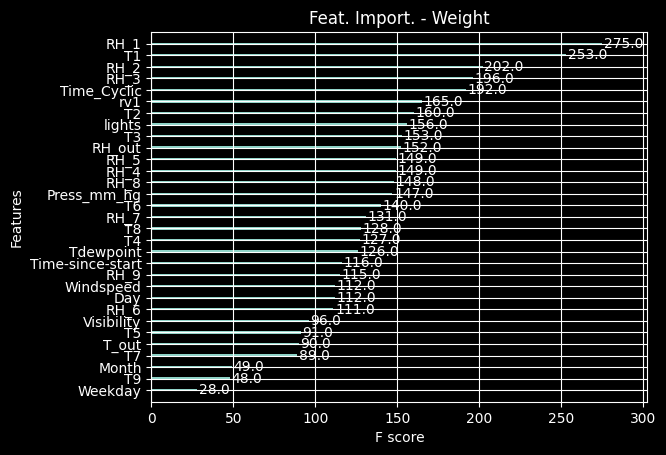

In [75]:
xgb.plot_importance(model, importance_type='weight', title='Feat. Import. - Weight')

<Axes: title={'center': 'Feat. Import. - Gain'}, xlabel='F score', ylabel='Features'>

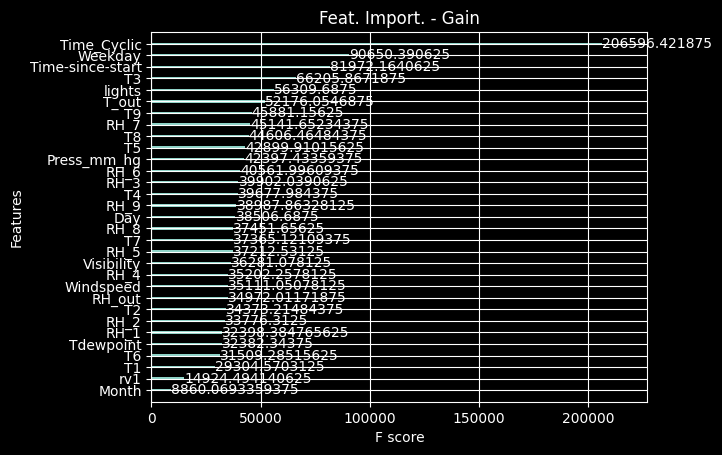

In [76]:
xgb.plot_importance(model, importance_type='gain', title='Feat. Import. - Gain')

## Training Predictions

In [115]:
pred = model.predict(X_test)
# pred_data = pd.DataFrame(pred)
# pred_data.to_csv('./ICE-2/ice-predictions.csv', index=False)

In [116]:
rmse = root_mean_squared_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
meanae = mean_absolute_error(y_test, pred)
medae = median_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

In [117]:
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {meanae:.5f}")
print(f"Median Absolute Error (MAE): {medae:.5f}")
print(f"R^2 Error (R^2): {r2:.5f}")

Root Mean Squared Error (RMSE): 71.13320
Mean Squared Error (MSE): 5059.93226
Mean Absolute Error (MAE): 36.90989
Median Absolute Error (MAE): 15.63345
R^2 Error (R^2): 0.50828


In [80]:
joblib.dump(model, 'ICE-2\\good_model.pkl')

['ICE-2\\good_model.pkl']

# Multi-Randomized

In [81]:
rdm_mdls = []
rdm_combis = []
rdm_nmbrs = []
rdm_stats = pd.DataFrame(columns=['Random Split', 'Random Model', 'Mean_Abs', 'Med_Abs', 'R2'])

# DO NOT LET THE RANGE GO HIGH, REMEMBER n!, n over 150 is undefined because it is too big, limit to at most 100
# 
for i in range(100):
    ran_int = random.randint(1, 10000)
    rdm_nmbrs.append(ran_int)

for combi in itertools.combinations(rdm_nmbrs, 2):
    rdm_combis.append(list(combi))

In [82]:
X_rdm = training_df.copy().drop(columns=['Year', 'Appliances'])
y_rdm = training_df['Appliances']

for i in range(0, len(rdm_combis)):
    combi_model = xgb.XGBRFRegressor(random_state=rdm_combis[i][1], enable_categorical=True)
    X_tmp_trn, X_tmp_tst, y_tmp_trn, y_tmp_tst = train_test_split(X_rdm, y_rdm, test_size=0.2, random_state=rdm_combis[i][0])

    # temp_test = X_tmp_tst.copy()
    combi_model.fit(X_tmp_trn, y_tmp_trn)
    rdm_mdls.append(combi_model)
    pred = combi_model.predict(X_tmp_tst)
    mean_er = mean_absolute_error(y_tmp_tst, pred)
    med_er = median_absolute_error(y_tmp_tst, pred)
    r2_er = r2_score(y_tmp_tst, pred)
    new_data = pd.DataFrame([[rdm_combis[i][0], rdm_combis[i][1], mean_er, med_er, r2_er]], columns=['Random Split', 'Random Model', 'Mean_Abs', 'Med_Abs', 'R2'])
    rdm_stats = pd.concat([rdm_stats, new_data], ignore_index=True)

C:\Users\Zhenterigone\AppData\Local\Temp\ipykernel_10356\1127492616.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rdm_stats = pd.concat([rdm_stats, new_data], ignore_index=True)


In [83]:
rdm_combi_sort_R2 = rdm_stats.sort_values(by='R2', ascending=False)

In [84]:
display(rdm_combi_sort_R2.head(5))
display(rdm_combi_sort_R2.tail(5))

,Random Split,Random Model,Mean_Abs,Med_Abs,R2
3323,5752,2329,45.562484,23.893570,0.291107
3341,5752,2729,45.560882,24.054096,0.290089
3314,5752,856,45.700843,23.970871,0.289251
3345,5752,4991,45.756476,24.028633,0.288068
3305,5752,8708,45.766610,23.925922,0.287800


,Random Split,Random Model,Mean_Abs,Med_Abs,R2
3405,2908,2124,47.474881,23.767063,0.209067
3387,2908,3298,47.561065,23.485382,0.208302
3362,2908,7014,47.516172,23.962559,0.208198
3406,2908,8064,47.569891,24.225334,0.208094
3385,2908,3501,47.620376,23.914598,0.206222


# Nueral Network
Ultimately wasn't used, took too long to make any reasonable progress

In [85]:
X_nn_trn, X_nn_tst, y_nn_trn, y_nn_tst = train_test_split(X, y, test_size=0.2, random_state=117)

In [95]:
nn_model = keras.Sequential()
nn_model.add(keras.layers.Dense(128, input_dim=len(X_nn_trn.columns), activation='relu'))
nn_model.add(keras.layers.Dense(256, activation='relu'))
nn_model.add(keras.layers.Dropout(.33))
nn_model.add(keras.layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(.15))
nn_model.add(keras.layers.Dense(1))

C:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,761 (210.00 KB)

 Trainable params: 53,761 (210.00 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
def r2_metric(y_true, y_pred):
    ss_total = keras.backend.sum(keras.backend.square(y_true - keras.backend.mean(y_true)))  # Total sum of squares
    ss_residual = keras.backend.sum(keras.backend.square(y_true - y_pred))  # Residual sum of squares
    return 1 - (ss_residual / ss_total)

In [106]:
opt = keras.optimizers.Adam()
nn_model.compile(loss=keras.losses.MeanSquaredError(), optimizer=opt, metrics=['mae'])

In [114]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
model_checkpoint = keras.callbacks.ModelCheckpoint('./ICE-2/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
history = nn_model.fit(X_nn_trn, y_nn_trn, epochs=2000, validation_split=0.35, batch_size=20, callbacks=[early_stop, model_checkpoint], shuffle=False)
hist = pd.DataFrame(history.history)

Epoch 1/2000
347/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9262.6582 - mae: 52.3336
Epoch 1: val_loss improved from inf to 9530.64062, saving model to ./ICE-2/best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9245.9434 - mae: 52.3518 - val_loss: 9530.6406 - val_mae: 45.4319
Epoch 2/2000
345/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9411.3027 - mae: 52.4344
Epoch 2: val_loss did not improve from 9530.64062
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9391.5723 - mae: 52.4652 - val_loss: 9715.0615 - val_mae: 45.8107
Epoch 3/2000
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9061.9248 - mae: 51.9785
Epoch 3: val_loss improved from 9530.64062 to 9409.20508, saving model to ./ICE-2/best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9061.3564 - mae: 51.9809 - val_loss: 9409.2051 - val_mae: 45.6059
Epoch 4/2000
347/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9206.4141 - mae: 52.5552
Epoch 4: val_loss did not improve from 9409.20508
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9193.5381 - mae: 52.5785 - val_loss: 9719.8398 - val_mae: 45.9983
Epoch 5/2000
355/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9313.5557 - mae: 52.0088
Epoch 5: val_loss improved from 9409.20508 to 9225.04785, saving model to ./ICE-2/best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9305.2686 - mae: 52.0326 - val_loss: 9225.0479 - val_mae: 45.9663
Epoch 6/2000
353/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9179.4502 - mae: 51.7131
Epoch 6: val_loss did not improve from 9225.04785
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9171.9941 - mae: 51.7379 - val_loss: 9768.0215 - val_mae: 46.3458
Epoch 7/2000
349/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9347.1494 - mae: 52.4844
Epoch 7: val_loss did not improve from 9225.04785
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9332.8828 - mae: 52.5071 - val_loss: 9443.4893 - val_mae: 45.1408
Epoch 8/2000
361/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9246.4072 - mae: 52.3807
Epoch 8: val_loss improved from 9225.04785 to 9195.28516, saving model to ./ICE-2/best_model.h5


362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9244.7588 - mae: 52.3832 - val_loss: 9195.2852 - val_mae: 45.4220
Epoch 9/2000
347/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9228.0488 - mae: 52.5052
Epoch 9: val_loss did not improve from 9195.28516
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9213.8779 - mae: 52.5321 - val_loss: 9403.9922 - val_mae: 45.0708
Epoch 10/2000
353/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9158.4863 - mae: 52.2467
Epoch 10: val_loss did not improve from 9195.28516
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9151.4473 - mae: 52.2623 - val_loss: 9257.1143 - val_mae: 45.3712
Epoch 11/2000
357/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9192.5645 - mae: 52.3700
Epoch 11: val_loss did not improve from 9195.28516
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9188.5947 - mae: 52.3765 - val_loss: 9285.3486 - val_mae: 45.7404
Epoch 12/2000
359/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9052.9951 - mae: 52.4895
Epoch 12: val_loss did not improve fr

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9228.9385 - mae: 52.8824 - val_loss: 9087.1592 - val_mae: 45.8448
Epoch 14/2000
359/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9169.1885 - mae: 52.3302
Epoch 14: val_loss did not improve from 9087.15918
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9165.7441 - mae: 52.3358 - val_loss: 9381.3398 - val_mae: 45.0882
Epoch 15/2000
354/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9185.0430 - mae: 52.2204
Epoch 15: val_loss did not improve from 9087.15918
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9176.9453 - mae: 52.2289 - val_loss: 9402.5850 - val_mae: 45.5810
Epoch 16/2000
351/362 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9099.4766 - mae: 51.7677
Epoch 16: val_loss did not improve from 9087.15918
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9090.8818 - mae: 51.7915 - val_loss: 9329.6709 - val_mae: 45.9534
Epoch 17/2000
347/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9322.6377 - mae: 53.0094
Epoch 17: val_loss did not improve 

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9194.2930 - mae: 52.1071 - val_loss: 8961.9619 - val_mae: 45.7007
Epoch 30/2000
361/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9121.2578 - mae: 52.1878
Epoch 30: val_loss did not improve from 8961.96191
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9119.7461 - mae: 52.1904 - val_loss: 9331.0605 - val_mae: 45.4874
Epoch 31/2000
359/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9172.2266 - mae: 51.8761
Epoch 31: val_loss did not improve from 8961.96191
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9169.2695 - mae: 51.8820 - val_loss: 9497.9961 - val_mae: 45.1364
Epoch 32/2000
348/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9075.7920 - mae: 52.6307
Epoch 32: val_loss did not improve from 8961.96191
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9065.9150 - mae: 52.6468 - val_loss: 9243.6953 - val_mae: 45.6603
Epoch 33/2000
355/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9110.3145 - mae: 52.0788
Epoch 33: val_loss did not improve 

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9152.4727 - mae: 52.0800 - val_loss: 8899.6836 - val_mae: 45.9544
Epoch 51/2000
361/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9239.7354 - mae: 52.1796
Epoch 51: val_loss did not improve from 8899.68359
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9237.8223 - mae: 52.1813 - val_loss: 9223.2881 - val_mae: 45.4627
Epoch 52/2000
349/362 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9061.1211 - mae: 51.4965
Epoch 52: val_loss did not improve from 8899.68359
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9051.4619 - mae: 51.5323 - val_loss: 9390.6016 - val_mae: 45.4843
Epoch 53/2000
354/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9115.5703 - mae: 51.5106
Epoch 53: val_loss did not improve from 8899.68359
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9107.0527 - mae: 51.5291 - val_loss: 9360.9844 - val_mae: 45.3144
Epoch 54/2000
345/362 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9032.4199 - mae: 51.9053
Epoch 54: val_loss did not improve 

In [112]:
preds = np.round(nn_model.predict(X_nn_tst),1)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


In [113]:
r2 = r2_score(y_nn_tst, preds)
print(r2)

0.04888492822647095


# Holdout Predictions

In [125]:
holdout_cln = holdout_df.drop(columns=['Year', 'Hours', 'Minutes'])
holdout_pred = model.predict(holdout_cln)
holdout_data = pd.DataFrame(holdout_pred, columns=['Appliances'])
holdout_data.to_csv('./ICE-2/ezekialcurran-appliance-predictions.csv', index=False)